This notebook is intended to run locally the Udemy Course

Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.


In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [7]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

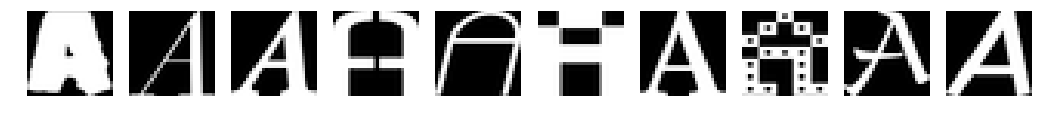

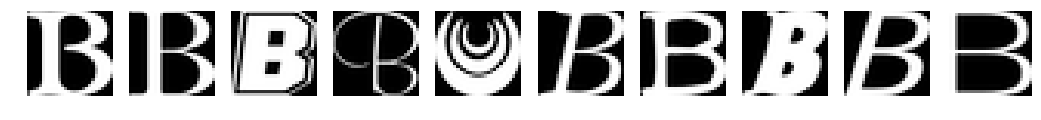

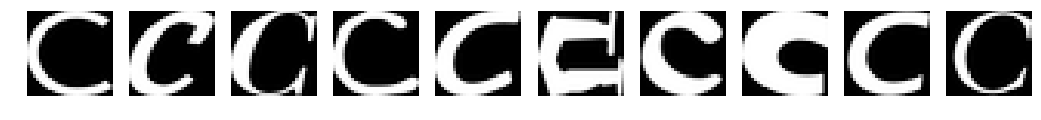

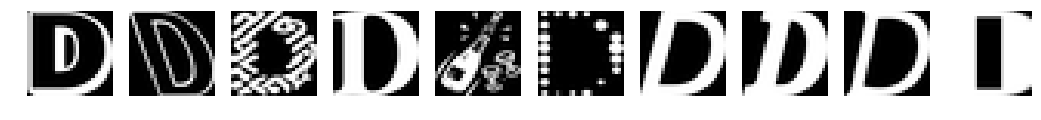

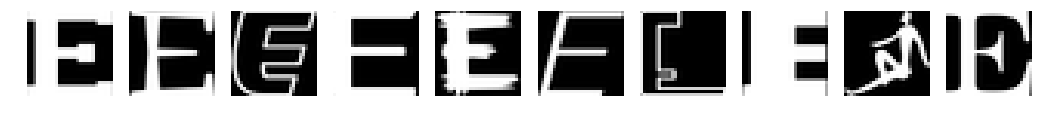

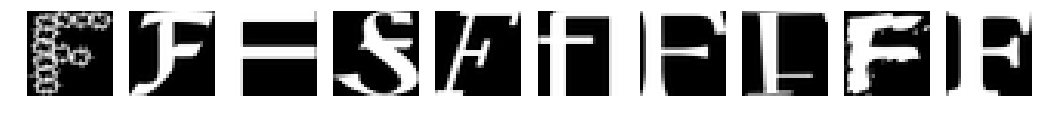

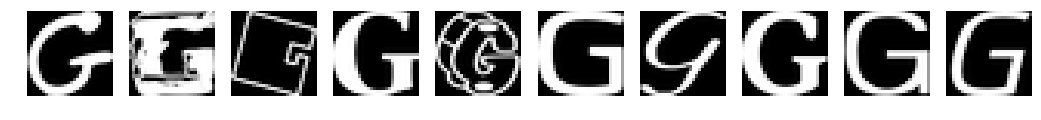

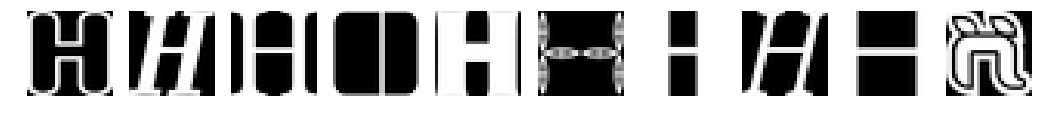

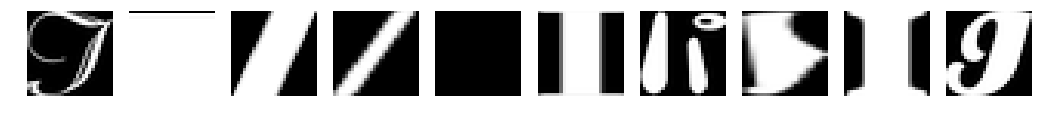

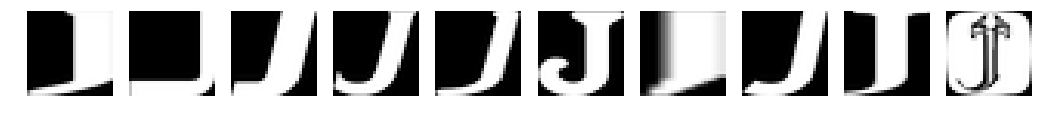

In [11]:
import random
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

## Solution using IPython Display
def showImagesHorizontally(folder, list_of_files):
    fig = figure(figsize=(18,5))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(os.path.join(folder,list_of_files[i]))
        imshow(image,cmap='Greys_r')
        axis('off')
        
for folder in train_folders:
    images_path = random.sample(os.listdir(folder), 10)
    showImagesHorizontally(folder, images_path)



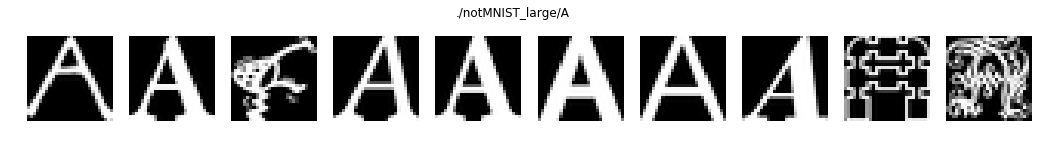

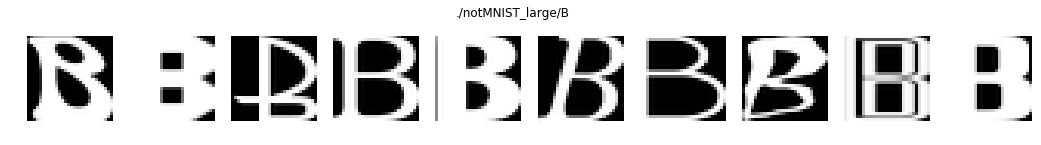

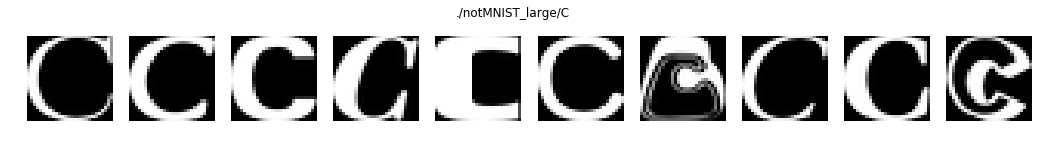

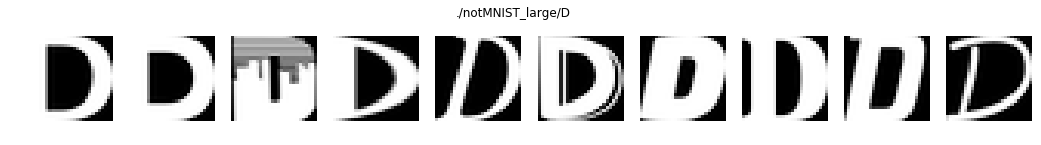

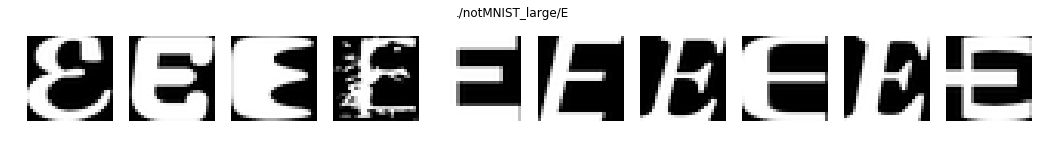

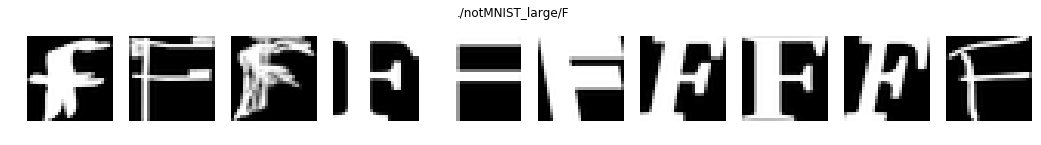

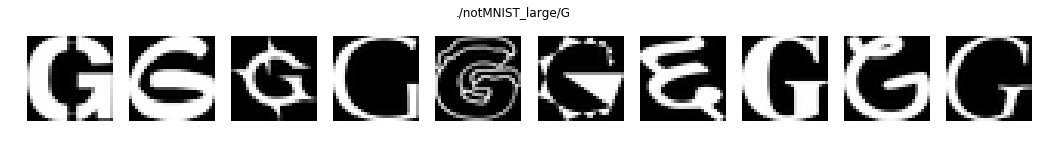

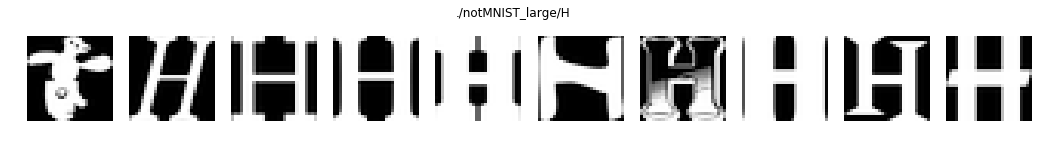

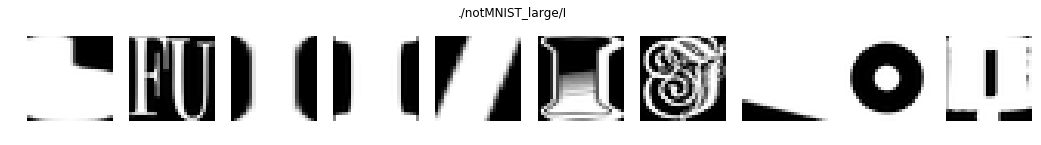

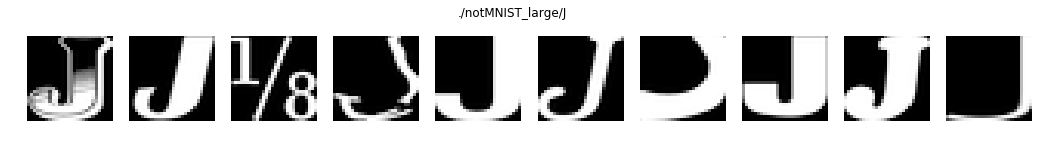

In [92]:
## Using Matplotlib 



## Solution using IPython Display
def showImagesHorizontally_matplotlib(folder, list_of_files):
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(folder,y=0.7, fontsize=12)


    number_of_files = len(list_of_files)
    for index, file_name in enumerate(list_of_files):

        ax = fig.add_subplot(1, len(list_of_files), index +  1)
        file_path = os.path.join(folder, file_name)

        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_axis_off()
        ax.imshow(image, cmap='Greys_r')
    
        
for folder in train_folders:
    images_path = random.sample(os.listdir(folder), 10)
    showImagesHorizontally_matplotlib(folder, images_path)



Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [12]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                             dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

# Change folder list for pickle list
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---


Dataset ./notMNIST_large/A.pickle contain 52909 images.
Dataset ./notMNIST_large/B.pickle contain 52911 images.
Dataset ./notMNIST_large/C.pickle contain 52912 images.
Dataset ./notMNIST_large/D.pickle contain 52911 images.
Dataset ./notMNIST_large/E.pickle contain 52912 images.
Dataset ./notMNIST_large/F.pickle contain 52912 images.
Dataset ./notMNIST_large/G.pickle contain 52912 images.
Dataset ./notMNIST_large/H.pickle contain 52912 images.
Dataset ./notMNIST_large/I.pickle contain 52912 images.
Dataset ./notMNIST_large/J.pickle contain 52911 images.
Mean size: 52911.4
Std size: 0.9165151389911681
Well balanced, with 10% threshold 52909.0
Well balanced, with 10% threshold 52911.0
Well balanced, with 10% threshold 52912.0
Well balanced, with 10% threshold 52911.0
Well balanced, with 10% threshold 52912.0
Well balanced, with 10% threshold 52912.0
Well balanced, with 10% threshold 52912.0
Well balanced, with 10% threshold 52912.0
Well balanced, with 10% threshold 52912.0
Well balanced,

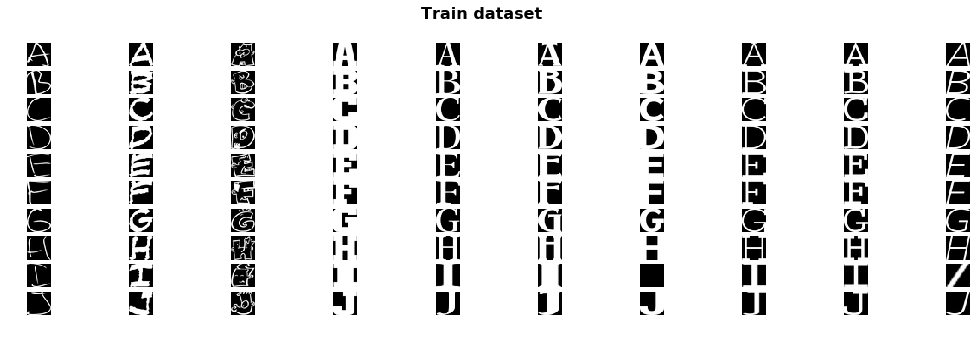

Dataset ./notMNIST_small/A.pickle contain 1872 images.
Dataset ./notMNIST_small/B.pickle contain 1873 images.
Dataset ./notMNIST_small/C.pickle contain 1873 images.
Dataset ./notMNIST_small/D.pickle contain 1873 images.
Dataset ./notMNIST_small/E.pickle contain 1873 images.
Dataset ./notMNIST_small/F.pickle contain 1872 images.
Dataset ./notMNIST_small/G.pickle contain 1872 images.
Dataset ./notMNIST_small/H.pickle contain 1872 images.
Dataset ./notMNIST_small/I.pickle contain 1872 images.
Dataset ./notMNIST_small/J.pickle contain 1872 images.
Mean size: 1872.4
Std size: 0.48989794855663565
Well balanced, with 10% threshold 1872.0
Well balanced, with 10% threshold 1873.0
Well balanced, with 10% threshold 1873.0
Well balanced, with 10% threshold 1873.0
Well balanced, with 10% threshold 1873.0
Well balanced, with 10% threshold 1872.0
Well balanced, with 10% threshold 1872.0
Well balanced, with 10% threshold 1872.0
Well balanced, with 10% threshold 1872.0
Well balanced, with 10% threshold

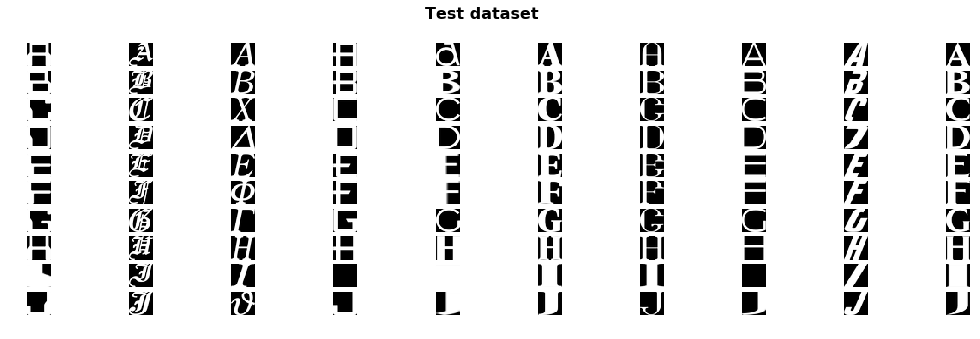

In [13]:
## Solution using IPython Display

def check_balance(arr):
    print('Mean size: {}'.format(arr.mean()))
    print('Std size: {}'.format(arr.std()))
    
    for i in arr:
        if abs(i - arr.mean()) > 0.1 * arr.mean():
            print("Too much or less images")
        else:
            print("Well balanced, with 10% threshold", i)
            
    
def plot_horizontal(datasets, sample_size=10, title='None'):
    fig = plt.figure(figsize=(18,5))
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    
    num_of_images = np.zeros(len(datasets))
        
    for i, pickle_file in enumerate(datasets):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)

            for index, image in enumerate(data):
                if index == sample_size: break
                ax = fig.add_subplot(len(datasets), sample_size, sample_size * datasets.index(pickle_file) +
                                     index + 1)
                ax.imshow(image, cmap='Greys_r')
                ax.set_axis_off()
            print('Dataset {} contain {} images.'.format(pickle_file, len(data)))    
            num_of_images[i] = len(data)
            
    check_balance(num_of_images)
    plt.show()

plot_horizontal(train_datasets, title='Train dataset')
plot_horizontal(test_datasets, title='Test dataset')



Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [14]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      print(pickle_file)
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

./notMNIST_large/A.pickle
./notMNIST_large/B.pickle
./notMNIST_large/C.pickle
./notMNIST_large/D.pickle
./notMNIST_large/E.pickle
./notMNIST_large/F.pickle
./notMNIST_large/G.pickle
./notMNIST_large/H.pickle
./notMNIST_large/I.pickle
./notMNIST_large/J.pickle
./notMNIST_small/A.pickle
./notMNIST_small/B.pickle
./notMNIST_small/C.pickle
./notMNIST_small/D.pickle
./notMNIST_small/E.pickle
./notMNIST_small/F.pickle
./notMNIST_small/G.pickle
./notMNIST_small/H.pickle
./notMNIST_small/I.pickle
./notMNIST_small/J.pickle
Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

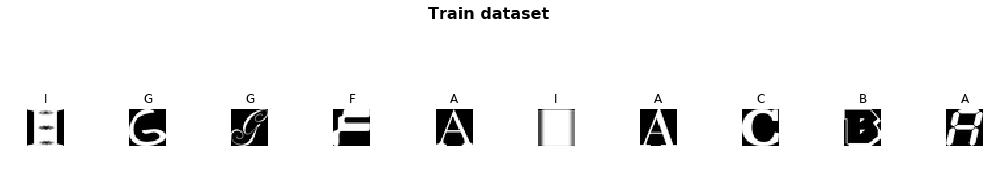

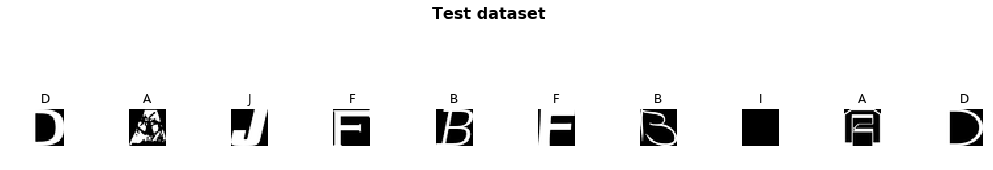

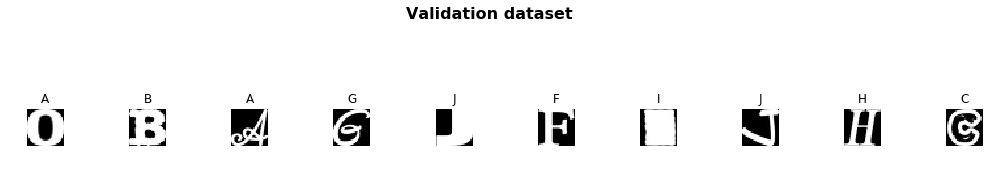

In [16]:
import string

def get_letter(pos):
    return string.ascii_uppercase[pos]

def plot_horizontal_np(dataset, labels, sample_size=10, title='None'):    
    fig = plt.figure(figsize=(18,8))
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    selection = random.sample(range(0,len(dataset)), 10)
    
    for i, index in enumerate(selection):
        ax = fig.add_subplot(10, sample_size, sample_size  +i + 1)
        ax.set_title(get_letter(labels[index]))
        ax.imshow(dataset[index],cmap='Greys_r')
        ax.set_axis_off()

    plt.show()

plot_horizontal_np(train_dataset, train_labels, title='Train dataset')
plot_horizontal_np(test_dataset, test_labels, title='Test dataset')
plot_horizontal_np(valid_dataset, valid_labels,  title='Validation dataset')



Finally, let's save the data for later reuse:

In [17]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [197]:
# well done by https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/1_notmnist.ipynb

def get_overlaps(dataset_1, dataset_2): 
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):     
            if np.array_equal(img_1, img_2):
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap



%time overlap_test_train = get_overlaps(test_dataset[:200], train_dataset)

CPU times: user 4min 56s, sys: 4.1 s, total: 5min
Wall time: 5min 29s


In [198]:

def get_overlaps_2(dataset_1, dataset_2): 
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):     
            if (img_1==img_2).all(): 
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap
%time overlap_test_train_2 = get_overlaps_2(test_dataset[:200], train_dataset)

CPU times: user 2min 50s, sys: 1.03 s, total: 2min 51s
Wall time: 2min 54s


In [18]:
import hashlib

def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

%time overlap_test_train_3 = extract_overlap_hash_where(test_dataset, train_dataset)
%time overlap_test_train_4 = extract_overlap_hash_where(test_dataset[:200], train_dataset)

CPU times: user 57.6 s, sys: 746 ms, total: 58.4 s
Wall time: 1min 5s
CPU times: user 3.6 s, sys: 60.5 ms, total: 3.66 s
Wall time: 3.77 s


Clearly we have a winner for checking for similarities!

In [205]:
print("{} similarities found using simple comparison".format(len(overlap_test_train)))
print("{} similarities found using np all comparison".format(len(overlap_test_train_2)))
print("{} similarities found using hash comparison".format(len(overlap_test_train_4)))
print("{} similarities found using hash comparison - all ".format(len(overlap_test_train_3)))

25 similarities found using simple comparison
25 similarities found using np all comparison
25 similarities found using hash comparison
1303 similarities found using hash comparison - all 


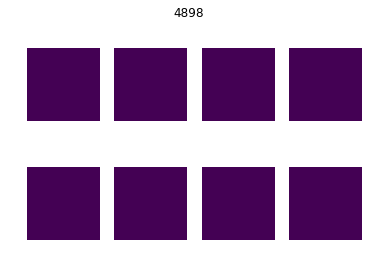

In [20]:
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.imshow(img)

    plt.show()
    
display_overlap(overlap_test_train_3, test_dataset, train_dataset)


In [21]:
# Remove duplicates, i.e. sanitized version

def sanitize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []  # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

test_dataset_sanit, test_labels_sanit = sanitize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))
valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)
pickle_file_sanit = 'notMNIST_sanit.pickle'


Overlapping images removed from test_dataset:  1258
Overlapping images removed from valid_dataset:  1061
Training: (200000, 28, 28) (200000,)
Validation: (8939,) (8939,)
Testing: (8742, 28, 28) (8742,)


In [22]:
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
    f = open(pickle_file_sanit, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683518846


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!


---

In [ ]:
def train_and_predict(sample_size):
    regr = LogisticRegression()
    X_train = train_dataset[:sample_size].reshape(sample_size, 784)
    y_train = train_labels[:sample_size]
    regr.fit(X_train, y_train)

    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels

    pred_labels = regr.predict(X_test)

    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)
    #disp_sample_dataset(test_dataset, pred_labels, 'sample_size=' + str(sample_size))


for sample_size in [50, 100, 1000, 5000, len(train_dataset)]:
    train_and_predict(sample_size)
    


Accuracy: 0.6424 when sample_size= 50
Accuracy: 0.7236 when sample_size= 100
Accuracy: 0.8327 when sample_size= 1000
Accuracy: 0.8481 when sample_size= 5000
